In [1]:
import os
from os.path import expanduser
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import shutil
from shapely import Point
from joblib import Parallel, delayed as delayed_joblib
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/home/patel_zeel/STGNP/dataset/bjair/NP_backup/processed_raw.csv")
df.columns

Index(['time', 'station_id', 'v_speed', 'u_speed', 'PM25_Concentration',
       'PM10_Concentration', 'NO2_Concentration', 'CO_Concentration',
       'O3_Concentration', 'SO2_Concentration', 'latitude', 'longitude',
       'temperature', 'pressure', 'humidity', 'wind_speed', 'PM25_Missing',
       'PM10_Missing', 'NO2_Missing', 'CO_Missing', 'O3_Missing',
       'SO2_Missing', 'weather_0.0', 'weather_1.0', 'weather_2.0',
       'weather_3.0', 'weather_4.0', 'weather_5.0', 'weather_6.0',
       'weather_7.0', 'weather_8.0', 'weather_9.0', 'weather_11.0',
       'weather_12.0', 'weather_13.0', 'weather_14.0', 'weather_15.0',
       'weather_16.0', 'wind_direction_0.0', 'wind_direction_1.0',
       'wind_direction_2.0', 'wind_direction_3.0', 'wind_direction_4.0',
       'wind_direction_9.0', 'wind_direction_13.0', 'wind_direction_14.0',
       'wind_direction_23.0', 'wind_direction_24.0'],
      dtype='object')

In [3]:
df = pd.read_csv("/home/patel_zeel/STGNP/dataset/bjair/NP_backup/processed_raw.csv")
stations_df = pd.read_csv("/home/patel_zeel/STGNP/dataset/bjair/NP_backup/stations.csv").set_index("station_id")

# replace missing values with np.nan
df["PM25_Missing"] = df["PM25_Missing"].apply(lambda x: 1 if x is False else np.nan)
df["PM25_Concentration"] = df["PM25_Concentration"] * df["PM25_Missing"]

# convert time to datetime
df["time"] = pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S")
df.rename(columns={"time": "datetime", "station_id": "location_id", "PM25_Concentration": "value"}, inplace=True)

# get ds
ds = df.set_index(["datetime", "location_id"])[["value", "pressure", "temperature", "humidity", "wind_speed"]].to_xarray()

# add lat lon
lats = [stations_df.loc[station_id, "latitude"] for station_id in ds.location_id.values]
lons = [stations_df.loc[station_id, "longitude"] for station_id in ds.location_id.values]
ds = ds.assign_coords({"lat": ("location_id", lats), "lon": ("location_id", lons)})
ds

<xarray.Dataset>
Dimensions:      (datetime: 8759, location_id: 35)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2014-05-01 ... 2015-04-30T22:00:00
  * location_id  (location_id) int64 1001 1002 1003 1004 ... 1033 1034 1035 1036
    lat          (location_id) float64 40.09 40.0 39.91 ... 39.71 39.52 39.58
    lon          (location_id) float64 116.2 116.2 116.2 ... 116.8 116.3 116.0
Data variables:
    value        (datetime, location_id) float64 138.0 89.0 105.0 ... 94.0 88.0
    pressure     (datetime, location_id) float64 1.004e+03 ... 1.004e+03
    temperature  (datetime, location_id) float64 20.0 20.0 20.0 ... 23.1 24.4
    humidity     (datetime, location_id) float64 56.0 56.0 56.0 ... 55.0 47.0
    wind_speed   (datetime, location_id) float64 7.92 7.92 7.92 ... 15.5 1.9 2.7

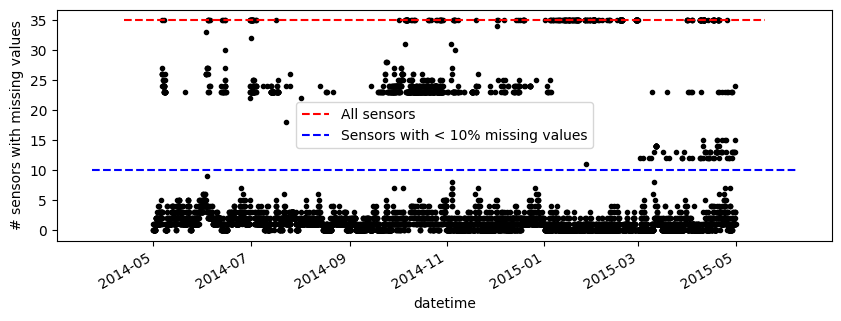

In [4]:
fig, ax = plt.subplots(figsize=(10, 3))
ds["value"].isnull().sum(dim="location_id").plot(
    ax=ax, x="datetime", marker="o", markersize=3, linestyle="", color="black"
)
plt.ylabel("# sensors with missing values")
plt.hlines(35, *plt.xlim(), color="red", linestyle="--", label="All sensors")
plt.hlines(10, *plt.xlim(), color="blue", linestyle="--", label="Sensors with < 10% missing values")
plt.legend();

In [5]:
(ds["value"].isnull().sum(dim="location_id") < 10).sum() / len(ds.datetime)

<xarray.DataArray 'value' ()>
array(0.85614796)

### Remove time-stamps with more than 10 sensors missing

In [6]:
valid_ts_idx = (ds["value"].isnull().sum(dim="location_id") < 10).values
valid_ts = ds.datetime.values[valid_ts_idx]
clean_ds = ds.sel(datetime=valid_ts)
clean_ds

<xarray.Dataset>
Dimensions:      (datetime: 7499, location_id: 35)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2014-05-01 ... 2015-04-30T22:00:00
  * location_id  (location_id) int64 1001 1002 1003 1004 ... 1033 1034 1035 1036
    lat          (location_id) float64 40.09 40.0 39.91 ... 39.71 39.52 39.58
    lon          (location_id) float64 116.2 116.2 116.2 ... 116.8 116.3 116.0
Data variables:
    value        (datetime, location_id) float64 138.0 89.0 105.0 ... 94.0 88.0
    pressure     (datetime, location_id) float64 1.004e+03 ... 1.004e+03
    temperature  (datetime, location_id) float64 20.0 20.0 20.0 ... 23.1 24.4
    humidity     (datetime, location_id) float64 56.0 56.0 56.0 ... 55.0 47.0
    wind_speed   (datetime, location_id) float64 7.92 7.92 7.92 ... 15.5 1.9 2.7

Text(0, 0.5, '# sensors with missing values')

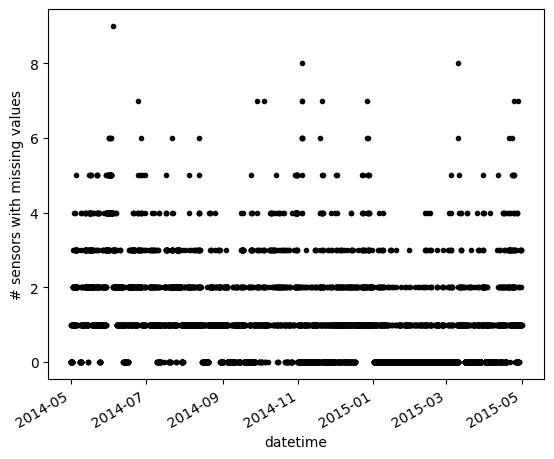

In [7]:
clean_ds["value"].isnull().sum(dim="location_id").plot(marker="o", markersize=3, linestyle="", color="black")
plt.ylabel("# sensors with missing values")

In [8]:
region = "bj_kdd23"
tmp_save_path = f"/opt/kdd24/data/beijing/{region}/data.nc"
os.makedirs(os.path.dirname(tmp_save_path), exist_ok=True)
clean_ds.to_netcdf(tmp_save_path)

In [9]:
locs = clean_ds.location_id.values
for fold_id, (train_idx, test_idx) in enumerate(KFold(n_splits=3, shuffle=True, random_state=0).split(locs)):
    print(len(test_idx), len(train_idx))
    tmp_save_path = f"/opt/kdd24/data/beijing/{region}/test_{fold_id}.npy"
    np.save(tmp_save_path, locs[test_idx])
    tmp_save_path = f"/opt/kdd24/data/beijing/{region}/train_{fold_id}.npy"
    np.save(tmp_save_path, locs[train_idx])

12 23
12 23
11 24


## Checks

In [10]:
np.isnan(clean_ds["value"]).sum()/(clean_ds["value"].shape[0] * clean_ds["value"].shape[1])

<xarray.DataArray 'value' ()>
array(0.03084983)